In [1]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran
import math

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [2]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=24,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [3]:
# DB Config
uid = "아파트4-103-106"

# TimeSlot In
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

hh_datas = pd.DataFrame(columns=['Date Time','kw (15min)'])
timeslot = hh_db_datas['timeslot']

wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

hh_datas['kw (15min)'] = [ts['power'] for ts in timeslot]
hh_datas['Date Time'] = [ts['time'] for ts in timeslot]

date_time = pd.to_datetime(hh_datas.pop('Date Time'), format="%Y-%m-%d T%H:%M Z")

hh_datas.index = date_time
hh_datas

,kw (15min)
Date Time,
2018-05-01 00:00:00,0.099
2018-05-01 00:15:00,0.103
2018-05-01 00:30:00,0.084
2018-05-01 00:45:00,0.079
2018-05-01 01:00:00,0.105
...,...
2019-04-30 22:45:00,0.030
2019-04-30 23:00:00,0.033
2019-04-30 23:15:00,0.038


In [4]:
# Split Data Code
split_datas = round(hh_datas[0::4], 3)

# Merging Data Code
count = 0
merge_datas = pd.DataFrame(columns=['kw (15min)'])
merge_datas['kw (15min)'] = [
    round(hh_datas[
        idx * 4:
        (idx + 1) * 4
    ].mean().values[0], 3)
    for idx in range(0, round(len(hh_datas) / 4))
]
merge_datas.index = [
    hh_datas.index[idx * 4]
    for idx in range(0, round(len(hh_datas) / 4))
]

In [62]:
split_sets = dict()

n = len(split_datas)
train_rate = int(n * 0.8)
val_rate = int(n * 0.9) + 12

split_sets['train'] = split_datas[0: train_rate]
split_sets['val'] = split_datas[train_rate: val_rate]
split_sets['test'] = split_datas[val_rate:]

In [63]:
train_mean = split_sets['train'].mean()
train_std = split_sets['train'].std()
print("split data // mean: {}, std: {}".format(train_mean.values, train_std.values))

norm_split = dict({
    "all": (split_datas - train_mean) / train_std,
    "train": (split_sets['train'] - train_mean) / train_std,
    "val": (split_sets['val'] - train_mean) / train_std,
    "test": (split_sets['test'] - train_mean) / train_std
})

split data // mean: [0.10904894], std: [0.1039964]


In [64]:
windows = dict()

for WINDOW_WIDTH in range(3, 21):
    windows['{} hours'.format(WINDOW_WIDTH)] = WindowGenerator(
        input_width=WINDOW_WIDTH,
        label_width=1,
        shift=1,
        label_columns=['kw (15min)'],
        train_df=norm_split['train'],
        val_df=norm_split['val'],
        test_df=norm_split['test']
    )

In [65]:
val_performance = dict()
performance = dict()
models = dict()

for WINDOW_WIDTH in range(3, 21):
    IPython.display.clear_output()
    key = "{} hours".format(WINDOW_WIDTH)
    print("##### {} training start #####".format(key))
    
    cur_window = windows[key]
    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])
    
    compile_and_fit(lstm_model, cur_window)
    val_performance[key] = lstm_model.evaluate(
                cur_window.val
            )
    performance[key] = lstm_model.evaluate(
                cur_window.test
            )
    models[key] = lstm_model

##### 20 hours training start #####
Epoch 1/40
292/292 [==============================] - 3s 6ms/step - loss: 0.9919 - mean_absolute_error: 0.6227 - val_loss: 0.6636 - val_mean_absolute_error: 0.6473
Epoch 2/40
292/292 [==============================] - 2s 5ms/step - loss: 0.9937 - mean_absolute_error: 0.6138 - val_loss: 0.6916 - val_mean_absolute_error: 0.6741
Epoch 3/40
36/36 [==============================] - 0s 2ms/step - loss: 0.6740 - mean_absolute_error: 0.7177


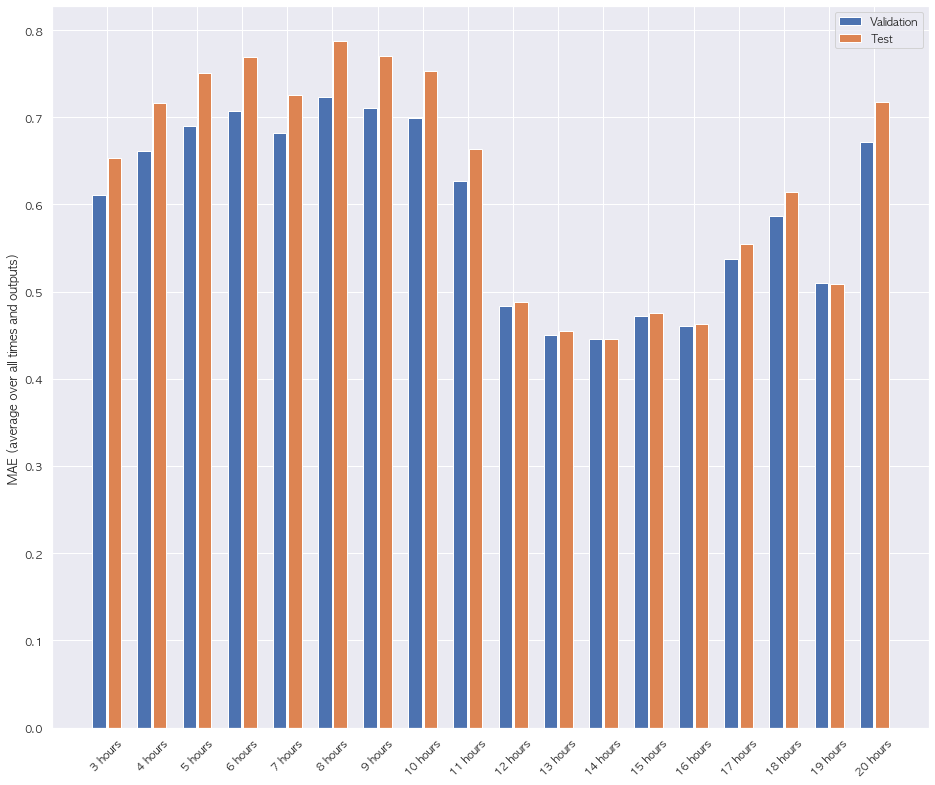

In [66]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

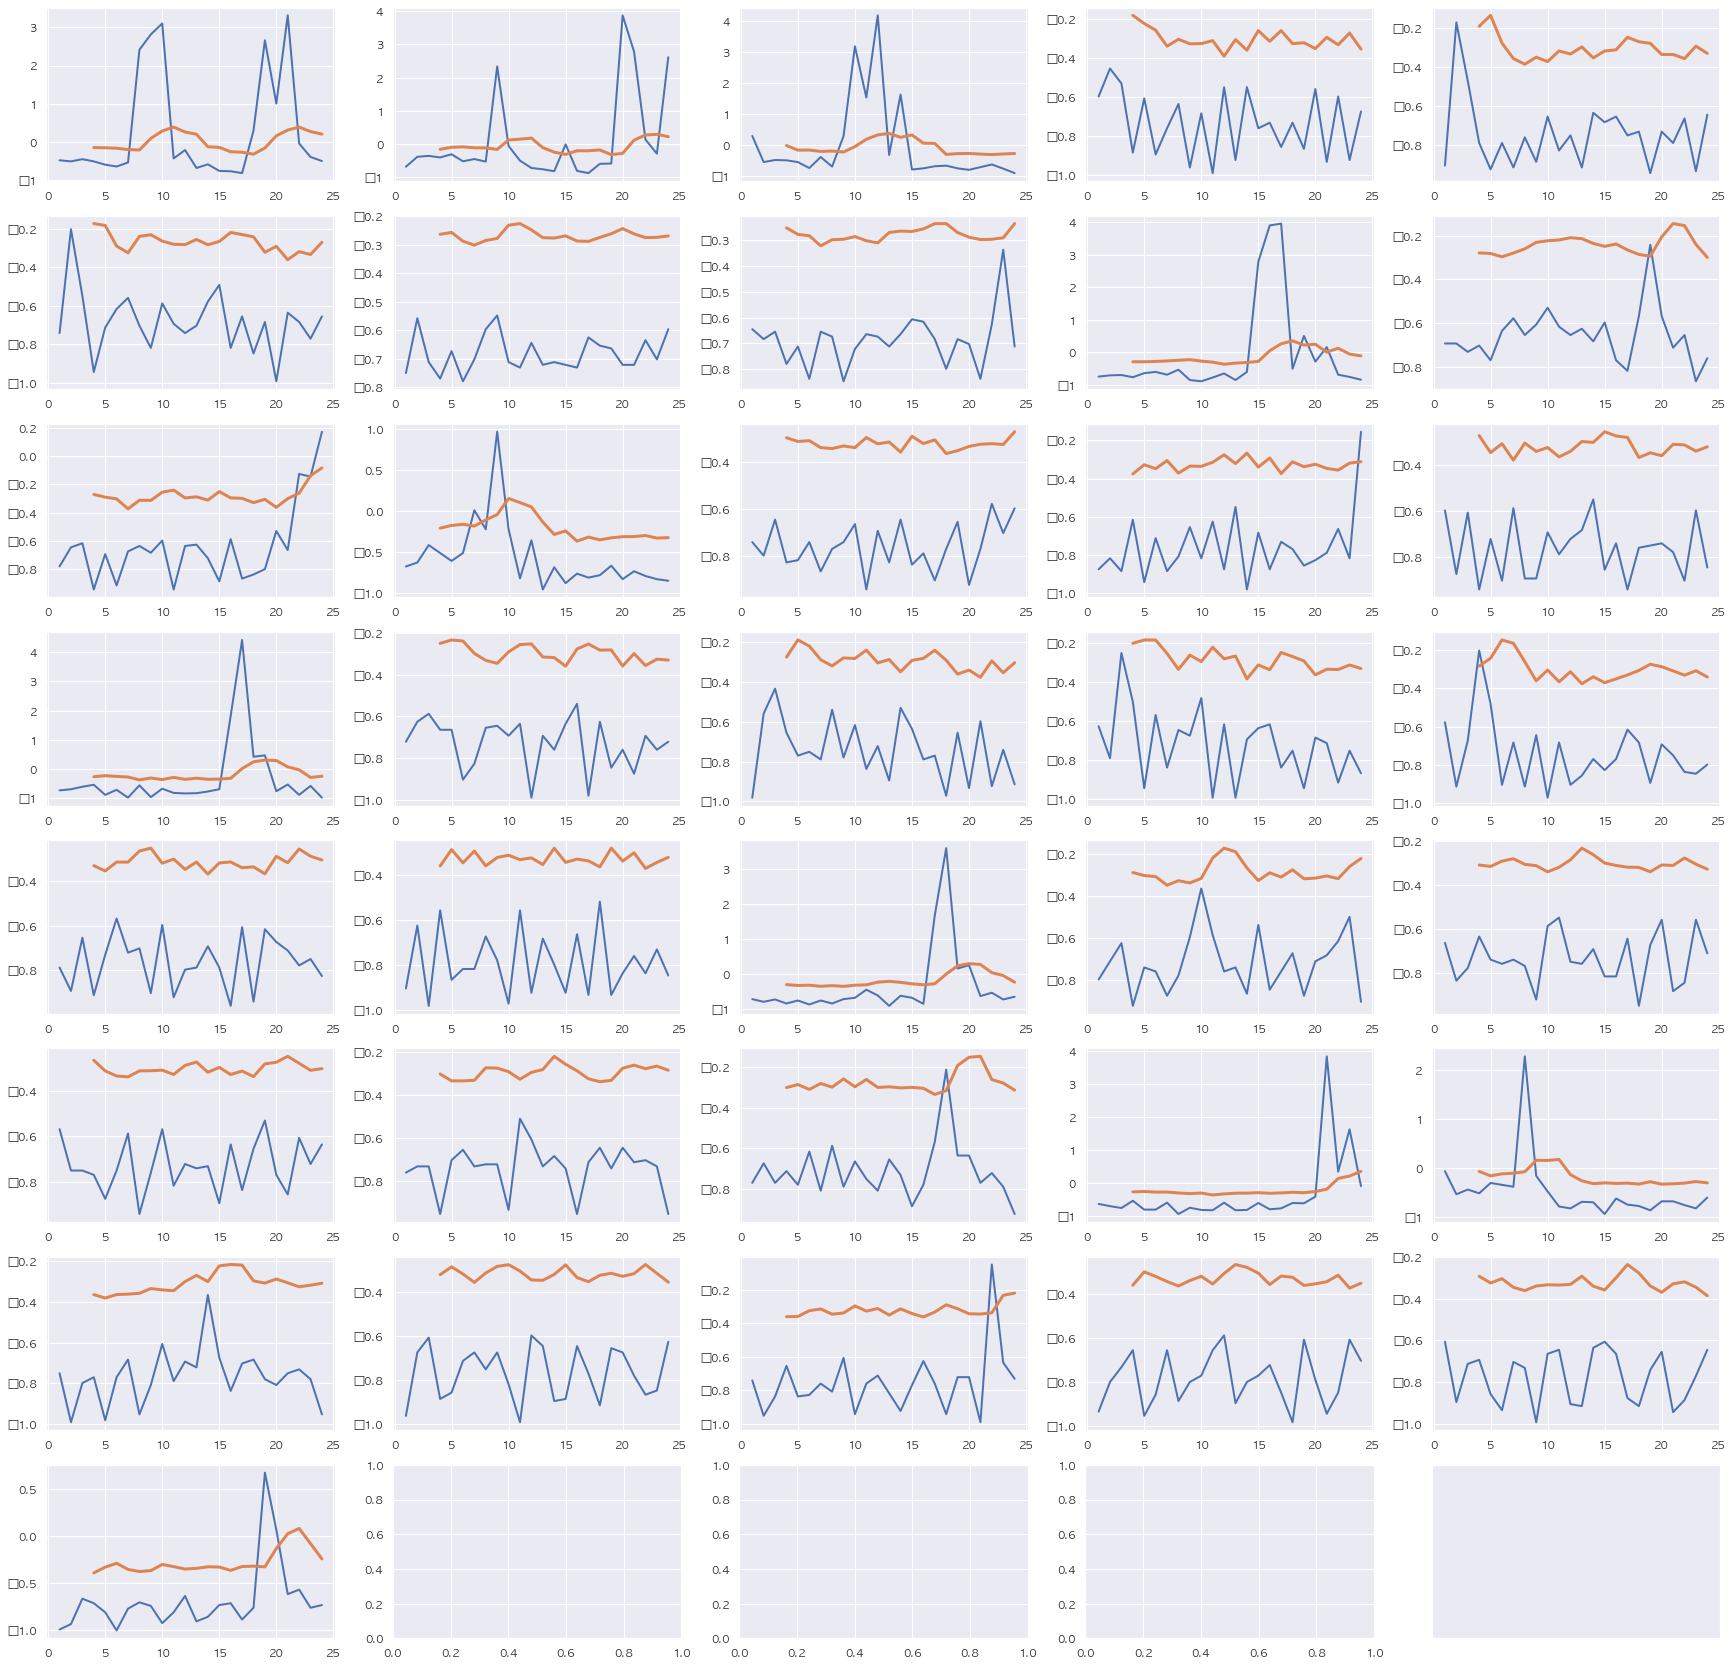

In [76]:
predict_data_length = 3
WINDOW_WIDTH = 13
fig, axes = plt.subplots(math.ceil(round(len(norm_split['test']) / 24) / 5),5, figsize=(30,30))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cnt = 0

for split in range(0, round(len(norm_split['test'])), 24):
    key = "{} hours".format(WINDOW_WIDTH)

    original_x_labels = [idx for idx in range(1,25)]
    predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
    original = norm_split['test'][split:(split + 24)].values.flatten()
    predicts = []
    inputs = []

    for idx in range(0, (24 - predict_data_length)):
        inputs = norm_split['test'][split:(split + 24)].values.flatten()[idx:predict_data_length + idx]
        inputs = inputs.reshape(-1, predict_data_length,1)
        result = models[key](inputs).numpy().flatten()[2]

        predicts.append(result)
        inputs = np.append(inputs.flatten()[1:predict_data_length],result)

    sns.lineplot(original_x_labels, original, lw=2, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
    sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
        
    cnt += 1      

In [74]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import euclidean as euc

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

predict_data_length = 3
WINDOW_WIDTH = 3
cnt = 0

evaluater = pd.DataFrame(columns=['mean dis', 'mean sim'])

for WINDOW_WIDTH in range(3, 21):
    print("WINDOW_WIDTH: {}".format(WINDOW_WIDTH))
    distances = np.array([])
    similarities = np.array([])
    for split in range(0, round(len(norm_split['test'])), 24):
        key = "{} hours".format(WINDOW_WIDTH)

        original_x_labels = [idx for idx in range(1,25)]
        predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
        original = norm_split['test'][split:(split + 24)].values.flatten()
        predicts = []
        inputs = []

        for idx in range(0, (24 - predict_data_length)):
            inputs = norm_split['test'][split:(split + 24)].values.flatten()[idx:predict_data_length + idx]
            inputs = inputs.reshape(-1,predict_data_length,1)
            result = models[key](inputs).numpy().flatten()[2]

            predicts.append(result)
            inputs = np.append(inputs.flatten()[1:predict_data_length],result)

        distances = np.append(distances, euc(original[predict_data_length:], predicts))
        similarities = np.append(similarities, cos_sim(original[predict_data_length:], predicts))
        cnt += 1
    evaluater.loc[key] = [distances.mean(), similarities.mean()]
        
evaluater

WINDOW_WIDTH: 3
WINDOW_WIDTH: 4
WINDOW_WIDTH: 5
WINDOW_WIDTH: 6
WINDOW_WIDTH: 7
WINDOW_WIDTH: 8
WINDOW_WIDTH: 9
WINDOW_WIDTH: 10
WINDOW_WIDTH: 11
WINDOW_WIDTH: 12
WINDOW_WIDTH: 13
WINDOW_WIDTH: 14
WINDOW_WIDTH: 15
WINDOW_WIDTH: 16
WINDOW_WIDTH: 17
WINDOW_WIDTH: 18
WINDOW_WIDTH: 19
WINDOW_WIDTH: 20


,mean dis,mean sim
3 hours,3.197770,0.826329
4 hours,3.610622,0.797927
5 hours,3.782997,0.710395
6 hours,3.868789,0.501013
7 hours,3.936384,0.092939
8 hours,3.956777,-0.428610
9 hours,3.895672,0.377196
10 hours,3.900460,0.358249
11 hours,3.791910,0.755633
12 hours,3.012626,0.821475


In [75]:
evaluater.sort_values(['mean dis', 'mean sim'], ascending=[True, False])

,mean dis,mean sim
13 hours,2.870071,0.829209
14 hours,2.904701,0.831950
12 hours,3.012626,0.821475
3 hours,3.197770,0.826329
15 hours,3.338873,0.842773
4 hours,3.610622,0.797927
16 hours,3.619227,0.824559
19 hours,3.724623,0.753963
17 hours,3.766556,0.767353
5 hours,3.782997,0.710395
